## Prepare mesh

In [1]:
!gmsh mesh.geo -setnumber geomtype 0 -o vacuum.msh -2 >& /dev/null
!convert_msh.py vacuum.msh vacuum.xdmf
!gmsh mesh.geo -setnumber geomtype 1 -o vacuum_metal.msh -2 >& /dev/null
!convert_msh.py vacuum_metal.msh vacuum_metal.xdmf
!gmsh mesh.geo -setnumber geomtype 2 -o vacuum_metal_vacuum.msh -2 >& /dev/null
!convert_msh.py vacuum_metal_vacuum.msh vacuum_metal_vacuum.xdmf

## Solution preparation

Import BeamImpedance2D module

In [2]:
import logging
import bi2d
from bi2d.materials import vacuum, beam
import numpy as np

Assign material indices. When setting index `-1` to SIBC material, boundary will be applied to all boundaries

In [3]:
beam.index = 1
vacuum.index = 2
steel = bi2d.Material(3, sigma=1e6)
outer_vacuum = vacuum.copy()
outer_vacuum.index = 4
wall = steel.copy()
wall.index = -1

Setup mesh and materials

In [4]:
m_v = bi2d.Mesh("vacuum.xdmf")
m_vm = bi2d.Mesh("vacuum_metal.xdmf")
m_vmv = bi2d.Mesh("vacuum_metal_vacuum.xdmf")
mc_v = bi2d.MaterialMap(m_v, [beam, vacuum])
mc_vm = bi2d.MaterialMap(m_vm, [beam, vacuum, steel])
mc_vmv = bi2d.MaterialMap(m_vmv, [beam, vacuum, steel, outer_vacuum])

Configure solution

In [5]:
solution_v = bi2d.Solution(mc_v, Hcurl_order=2, H1_order=2)
solution_vm = bi2d.Solution(mc_vm, Hcurl_order=2, H1_order=2)
solution_vmv = bi2d.Solution(mc_vmv, Hcurl_order=2, H1_order=2)
solution_v.logger.setLevel(logging.WARNING)
solution_vm.logger.setLevel(logging.WARNING)
solution_vmv.logger.setLevel(logging.WARNING)

## Calculate monopole impedance

Calculate impedance in frequency range and save the results

In [6]:
%%time

data_monopole_metal = solution_vm.get_z(np.logspace(3, 8, num=100), beta=0.999999, source_function=bi2d.SourceFunction.MONOPOLE)

CPU times: user 21min 15s, sys: 56.7 s, total: 22min 12s
Wall time: 22min 13s


In [7]:
%%time

data_monopole_sibc = solution_v.get_z(np.logspace(6, 12, num=100), beta=0.999999, source_function=bi2d.SourceFunction.MONOPOLE, sibc=[wall])

CPU times: user 10min 55s, sys: 36.3 s, total: 11min 32s
Wall time: 11min 33s


In [8]:
iw2d_monopole = np.genfromtxt("ZlongWthin_pipe_2layers40.00mm_0_999999beta.dat", skip_header=1)

## Plot monopole impedance

In [9]:
import pylab
pylab.rcParams['figure.figsize'] = [12, 8]

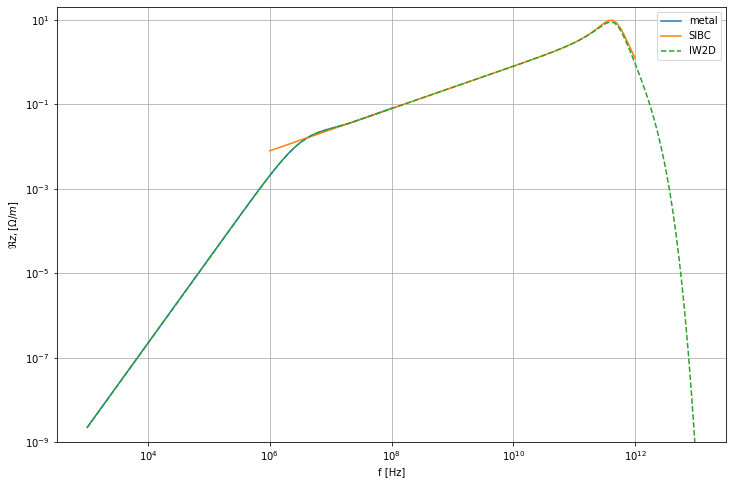

In [10]:
pylab.plot(data_monopole_metal[:,0], data_monopole_metal[:,1])
pylab.plot(data_monopole_sibc[:,0], data_monopole_sibc[:,1])
pylab.plot(iw2d_monopole[:,0], iw2d_monopole[:,1], linestyle="--")
pylab.ylim((1e-9, 2e1))
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f [Hz]")
pylab.ylabel(r"$\Re{z}, [\Omega/m]$")
pylab.grid()
pylab.legend(["metal", "SIBC", "IW2D"])
pylab.show()

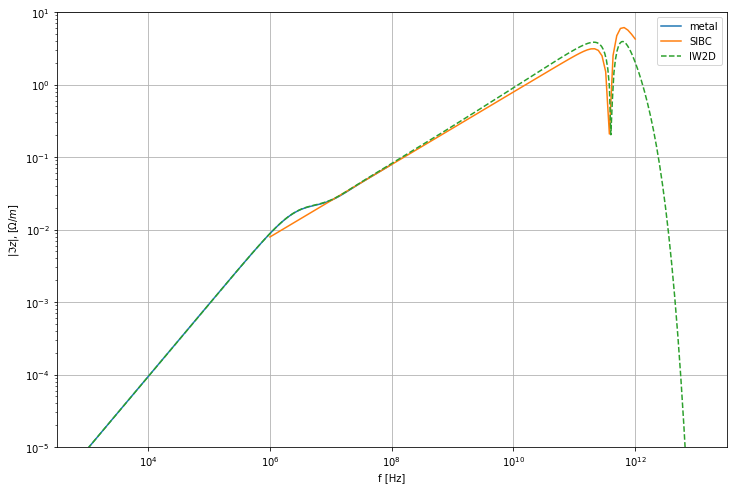

In [11]:
pylab.plot(data_monopole_metal[:,0], np.abs(data_monopole_metal[:,2]))
pylab.plot(data_monopole_sibc[:,0], np.abs(data_monopole_sibc[:,2]))
pylab.plot(iw2d_monopole[:,0], np.abs(iw2d_monopole[:,2]), linestyle="--")
pylab.ylim((1e-5, 1e1))
pylab.xscale("log")
pylab.yscale("log")
pylab.xlabel("f [Hz]")
pylab.ylabel(r"$|\Im{z}|, [\Omega/m]$")
pylab.grid()
pylab.legend(["metal", "SIBC", "IW2D"])
pylab.show()

## Calculate dipole impedance

Calculate impedance in frequency range and save the results

In [12]:
%%time

data_dipole_metal = solution_vmv.get_z(np.logspace(3, 8, num=100), beta=0.999999, source_function=bi2d.SourceFunction.DIPOLE)

CPU times: user 28min 3s, sys: 1min 31s, total: 29min 35s
Wall time: 29min 38s


In [13]:
%%time

data_dipole_sibc = solution_v.get_z(np.logspace(6, 12, num=100), beta=0.999999, source_function=bi2d.SourceFunction.DIPOLE, sibc=[wall])

CPU times: user 10min 39s, sys: 23.7 s, total: 11min 2s
Wall time: 11min 3s


In [14]:
iw2d_dipole = np.genfromtxt("ZxdipWthin_pipe_2layers40.00mm_0_999999beta.dat", skip_header=1)

## Plot dipole impedance

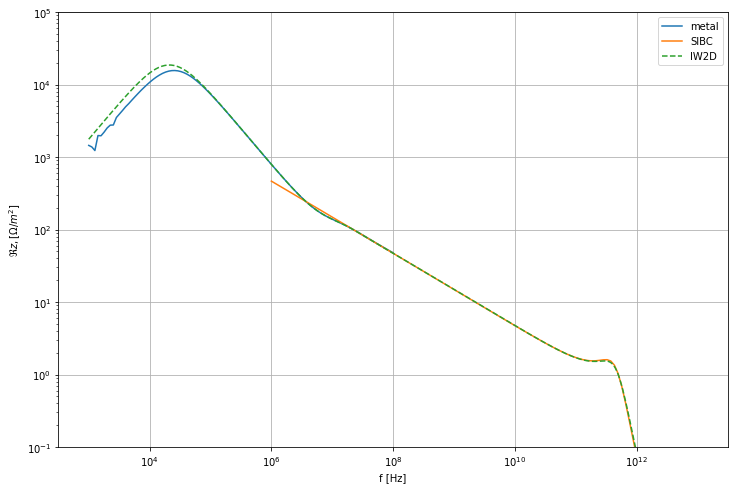

In [15]:
pylab.plot(data_dipole_metal[:,0], data_dipole_metal[:,1])
pylab.plot(data_dipole_sibc[:,0], data_dipole_sibc[:,1])
pylab.plot(iw2d_dipole[:,0], iw2d_dipole[:,1], linestyle="--")
pylab.ylim((1e-1, 1e5))
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f [Hz]")
pylab.ylabel(r"$\Re{z}, [\Omega/m^2]$")
pylab.grid()
pylab.legend(["metal", "SIBC", "IW2D"])
pylab.show()

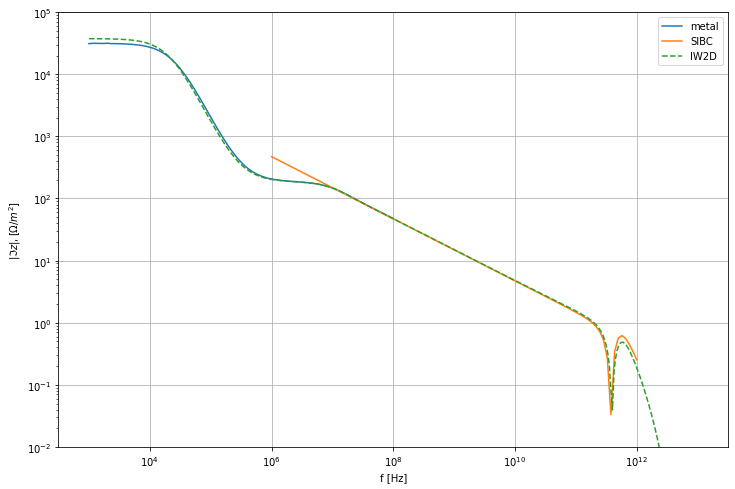

In [16]:
pylab.plot(data_dipole_metal[:,0], np.abs(data_dipole_metal[:,2]))
pylab.plot(data_dipole_sibc[:,0], np.abs(data_dipole_sibc[:,2]))
pylab.plot(iw2d_dipole[:,0], np.abs(iw2d_dipole[:,2]), linestyle="--")
pylab.ylim((1e-2, 1e5))
pylab.xscale("log")
pylab.yscale("log")
pylab.xlabel("f [Hz]")
pylab.ylabel(r"$|\Im{z}|, [\Omega/m^2]$")
pylab.grid()
pylab.legend(["metal", "SIBC", "IW2D"])
pylab.show()